### Case Study

FTX allows customers to trade based on the size of Move for Bitcoin. If we can determine a model, which can forecast better than 50/50 accuracy, whether or not Bitcoins move will likely be above it's average, then we have an edge.

The catch is, how to predict whether future volatility will be above or below the rolling average (assuming that the rolling average is where the market adjusts to). Regardless, this will be a significant challenge and we will need state-of-the-art methods, whilst making sure we do not overfit.

### Imports

In [1]:
import numpy as np
import pandas as pd
from stratmanager import StrategyManager
import sklearn.mixture as mix
from ta.momentum import RSIIndicator
import matplotlib.pyplot as plt

### Data Extraction and Returns Overview

In [2]:
# Extract Data
start_date = "2017-01-01"
end_date = "2022-06-01"
symbol = "BTC-USD"
strat_mgr = StrategyManager(symbol, start_date, end_date)
df = strat_mgr.df.copy()
df.head()

Open         High          Low        Close     Volume  \
Date                                                                        
2017-01-02   998.617004  1031.390015   996.702026  1021.750000  222184992   
2017-01-03  1021.599976  1044.079956  1021.599976  1043.839966  185168000   
2017-01-04  1044.400024  1159.420044  1044.400024  1154.729980  344945984   
2017-01-05  1156.729980  1191.099976   910.416992  1013.380005  510199008   
2017-01-06  1014.239990  1046.810059   883.943970   902.200989  351876000   

             Returns     Range  Bench_C_Rets  
Date                                          
2017-01-02  0.023464  0.034803      0.023314  
2017-01-03  0.021620  0.022005      0.045999  
2017-01-04  0.106233  0.110130      0.159122  
2017-01-05 -0.122410  0.308302      0.018098  
2017-01-06 -0.109711  0.184249     -0.092307

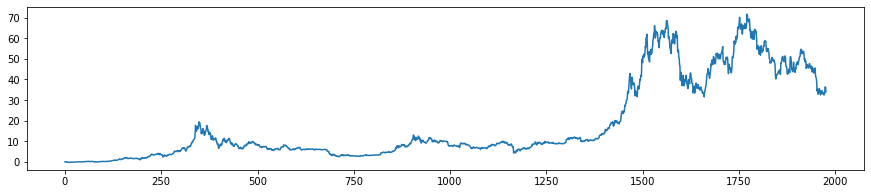

In [3]:
# Benchmark Returns Profile
fig = plt.figure(figsize = (15, 3))
plt.plot(df["Bench_C_Rets"].values)
plt.show()

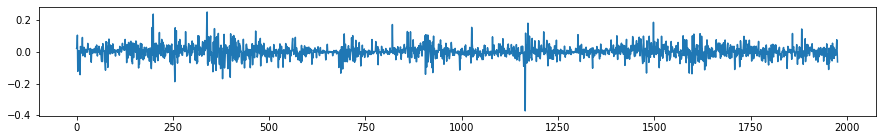

In [4]:
# Benchmark Returns Profile
fig = plt.figure(figsize = (15, 2))
plt.plot(df["Returns"].values)
plt.show()

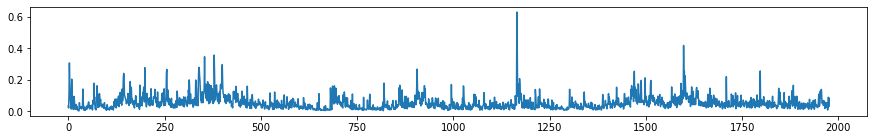

In [5]:
# Benchmark Range Profile
fig = plt.figure(figsize = (15, 2))
plt.plot(df["Range"].values)
plt.show()

### Feature Engineering - Feature Expansion

In [6]:
# Create a copy
df_fe = df.copy()

##### Indicators

In [7]:
# Add RSI
rsi = RSIIndicator(close=df_fe["Close"], window=14).rsi()
df_fe["RSI"] = rsi
df_fe["RSI_Ret"] = df_fe["RSI"] / df_fe["RSI"].shift(1)

In [8]:
# Add Moving Average
df_fe["MA_12"] = df_fe["Close"].rolling(window=12).mean()
df_fe["MA_21"] = df_fe["Close"].rolling(window=21).mean()

In [9]:
# Day of Week
df_fe["DOW"] = df_fe.index.dayofweek

In [10]:
# Rolling Cumulative Returns
df_fe["Roll_Rets"] = df_fe["Returns"].rolling(window=30).sum()

In [11]:
# Rolling Cumulative Range
df_fe["Avg_Range"] = df_fe["Range"].rolling(window=30).mean()

##### Time Intervals

In [12]:
# Add Time Intervals
t_steps = [1, 2]
t_features = ["Returns", "Range", "RSI_Ret"]
for ts in t_steps:
    for tf in t_features:
        df_fe[f"{tf}_T{ts}"] = df_fe[tf].shift(ts)

In [13]:
# Show DataFrame
df_fe.head(3)

Open         High          Low        Close     Volume  \
Date                                                                        
2017-01-02   998.617004  1031.390015   996.702026  1021.750000  222184992   
2017-01-03  1021.599976  1044.079956  1021.599976  1043.839966  185168000   
2017-01-04  1044.400024  1159.420044  1044.400024  1154.729980  344945984   

             Returns     Range  Bench_C_Rets  RSI  RSI_Ret  ...  MA_21  DOW  \
Date                                                        ...               
2017-01-02  0.023464  0.034803      0.023314  NaN      NaN  ...    NaN    0   
2017-01-03  0.021620  0.022005      0.045999  NaN      NaN  ...    NaN    1   
2017-01-04  0.106233  0.110130      0.159122  NaN      NaN  ...    NaN    2   

            Roll_Rets  Avg_Range  Returns_T1  Range_T1  RSI_Ret_T1  \
Date                                                                 
2017-01-02        NaN        NaN         NaN       NaN         NaN   
2017-01-03        NaN        NaN    0.023464  0.034803         NaN   
2017-01-04        NaN        NaN    0.021620  0.022005         NaN   

            Returns_T2  Range_T2  RSI_Ret_T2  
Date                                          
2017-01-02         NaN       NaN         NaN  
2017-01-03         NaN       NaN         NaN  
2017-01-04    0.023464  0.034803         NaN  

[3 rows x 21 columns]

### Feature Engineering - Feature Scaling

In [14]:
# Correct for Stationarity
df_fs = df_fe.copy()
df_fs[["Open", "High", "Low", "Volume"]] = df_fs[["Open", "High", "Low", "Volume"]].pct_change()
df_fs

Open      High       Low         Close    Volume   Returns  \
Date                                                                         
2017-01-02       NaN       NaN       NaN   1021.750000       NaN  0.023464   
2017-01-03  0.023015  0.012304  0.024980   1043.839966 -0.166604  0.021620   
2017-01-04  0.022318  0.110471  0.022318   1154.729980  0.862881  0.106233   
2017-01-05  0.107555  0.027324 -0.128287   1013.380005  0.479069 -0.122410   
2017-01-06 -0.123183 -0.121140 -0.029078    902.200989 -0.310316 -0.109711   
...              ...       ...       ...           ...       ...       ...   
2022-05-28 -0.021487 -0.018129  0.008047  28814.900391 -0.029042  0.006544   
2022-05-29  0.013879  0.023707  0.010035  29445.957031 -0.490594  0.021900   
2022-05-30  0.014593  0.083111  0.016035  31726.390625  1.170788  0.077445   
2022-05-31  0.077454  0.009397  0.067657  31792.310547 -0.146132  0.002078   
2022-06-01  0.002165 -0.009072 -0.057040  29799.080078  0.226536 -0.062695   

               Range  Bench_C_Rets        RSI   RSI_Ret  ...         MA_21  \
Date                                                     ...                 
2017-01-02  0.034803      0.023314        NaN       NaN  ...           NaN   
2017-01-03  0.022005      0.045999        NaN       NaN  ...           NaN   
2017-01-04  0.110130      0.159122        NaN       NaN  ...           NaN   
2017-01-05  0.308302      0.018098        NaN       NaN  ...           NaN   
2017-01-06  0.184249     -0.092307        NaN       NaN  ...           NaN   
...              ...           ...        ...       ...  ...           ...   
2022-05-28  0.009117     32.894788  37.238957  1.027560  ...  29874.254371   
2022-05-29  0.022777     33.634047  40.613855  1.090628  ...  29654.573010   
2022-05-30  0.090298     36.313300  50.890862  1.253042  ...  29722.641462   
2022-05-31  0.030803     36.391116  51.154006  1.005171  ...  29759.279762   
2022-06-01  0.083239     34.041939  43.554422  0.851437  ...  29800.361886   

            DOW  Roll_Rets  Avg_Range  Returns_T1  Range_T1  RSI_Ret_T1  \
Date                                                                      
2017-01-02    0        NaN        NaN         NaN       NaN         NaN   
2017-01-03    1        NaN        NaN    0.023464  0.034803         NaN   
2017-01-04    2        NaN        NaN    0.021620  0.022005         NaN   
2017-01-05    3        NaN        NaN    0.106233  0.110130         NaN   
2017-01-06    4        NaN        NaN   -0.122410  0.308302         NaN   
...         ...        ...        ...         ...       ...         ...   
2022-05-28    5  -0.298233   0.056286   -0.021856  0.036020    0.949541   
2022-05-29    6  -0.247068   0.055605    0.006544  0.009117    1.027560   
2022-05-30    0  -0.146443   0.057666    0.021900  0.022777    1.090628   
2022-05-31    1  -0.164364   0.057768    0.077445  0.090298    1.253042   
2022-06-01    2  -0.228625   0.059741    0.002078  0.030803    1.005171   

            Returns_T2  Range_T2  RSI_Ret_T2  
Date                                          
2017-01-02         NaN       NaN         NaN  
2017-01-03         NaN       NaN         NaN  
2017-01-04    0.023464  0.034803         NaN  
2017-01-05    0.021620  0.022005         NaN  
2017-01-06    0.106233  0.110130         NaN  
...                ...       ...         ...  
2022-05-28   -0.009984  0.055632    0.977232  
2022-05-29   -0.021856  0.036020    0.949541  
2022-05-30    0.006544  0.009117    1.027560  
2022-05-31    0.021900  0.022777    1.090628  
2022-06-01    0.077445  0.090298    1.253042  

[1977 rows x 21 columns]

### Assess Data for ML Readiness

In [17]:
# Check for NaN
df_fs.dropna(inplace=True)
print(df_fs.isnull().values.any())

False


In [18]:
# Check for Inf values
dfobj = df_fs.isin([np.inf, -np.inf])
count = np.isinf(dfobj).values.sum()
count

0

In [19]:
# Check for non-numerical objects
df_fs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1948 entries, 2017-01-31 to 2022-06-01
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1948 non-null   float64
 1   High          1948 non-null   float64
 2   Low           1948 non-null   float64
 3   Close         1948 non-null   float64
 4   Volume        1948 non-null   float64
 5   Returns       1948 non-null   float64
 6   Range         1948 non-null   float64
 7   Bench_C_Rets  1948 non-null   float64
 8   RSI           1948 non-null   float64
 9   RSI_Ret       1948 non-null   float64
 10  MA_12         1948 non-null   float64
 11  MA_21         1948 non-null   float64
 12  DOW           1948 non-null   int64  
 13  Roll_Rets     1948 non-null   float64
 14  Avg_Range     1948 non-null   float64
 15  Returns_T1    1948 non-null   float64
 16  Range_T1      1948 non-null   float64
 17  RSI_Ret_T1    1948 non-null   float64
 18  Returns_T2

In [20]:
# Describe DataFrame
df_fs.describe()

Open         High          Low         Close       Volume  \
count  1948.000000  1948.000000  1948.000000   1948.000000  1948.000000   
mean      0.002678     0.002466     0.002671  17584.016692     0.034165   
std       0.041308     0.036148     0.041701  17580.251574     0.285525   
min      -0.365924    -0.263712    -0.364062    937.520020    -0.869188   
25%      -0.015723    -0.012385    -0.012357   6307.839966    -0.122422   
50%       0.002232    -0.000083     0.003320   9218.806152    -0.007011   
75%       0.020771     0.016432     0.019551  31647.507812     0.145470   
max       0.250461     0.245708     0.247892  67566.828125     5.439003   

           Returns        Range  Bench_C_Rets          RSI      RSI_Ret  ...  \
count  1948.000000  1948.000000   1948.000000  1948.000000  1948.000000  ...   
mean      0.002647     0.054621     18.374284    53.346972     1.005146  ...   
std       0.041343     0.045446     19.596295    14.530654     0.104686  ...   
min      -0.371695     0.004622     -0.044698     9.920239     0.453659  ...   
25%      -0.015915     0.026334      5.906450    43.035353     0.953961  ...   
50%       0.002280     0.042897      8.904901    52.554932     1.005988  ...   
75%       0.021128     0.067155     33.886213    63.277076     1.047635  ...   
max       0.252472     0.631387     71.644966    94.302215     1.926078  ...   

              MA_21          DOW    Roll_Rets    Avg_Range   Returns_T1  \
count   1948.000000  1948.000000  1948.000000  1948.000000  1948.000000   
mean   17435.301216     2.998460     0.080204     0.054501     0.002680   
std    17503.602731     2.000128     0.252367     0.024838     0.041316   
min      885.613522     0.000000    -0.844981     0.015818    -0.371695   
25%     6418.352429     1.000000    -0.080312     0.036463    -0.015865   
50%     9217.704892     3.000000     0.052617     0.049099     0.002280   
75%    32930.640090     5.000000     0.248467     0.067058     0.021128   
max    63016.876488     6.000000     1.154731     0.138628     0.252472   

          Range_T1   RSI_Ret_T1   Returns_T2     Range_T2   RSI_Ret_T2  
count  1948.000000  1948.000000  1948.000000  1948.000000  1948.000000  
mean      0.054580     1.005224     0.002678     0.054567     1.005217  
std       0.045456     0.104628     0.041316     0.045467     0.104629  
min       0.003887     0.453659    -0.371695     0.003887     0.453659  
25%       0.026297     0.954048    -0.015865     0.026283     0.954048  
50%       0.042881     1.005988     0.002280     0.042881     1.005988  
75%       0.067125     1.047635     0.021128     0.067125     1.047635  
max       0.631387     1.926078     0.252472     0.631387     1.926078  

[8 rows x 21 columns]

### Save Data

In [21]:
# Save DataFrame
df_fs.to_csv(f"data/{symbol}.csv")